# 0.0 SOLUTION PLANNING (IOT)

**Input**
1. Business Problem
    - Select the most valuable customers to join a loyalty program (Insiders program).
#
2. Data
    - E-commerce sales over 1 year period.

**Output**

1. The indication of people who will be part of the Insiders program
    - List:          client_id | is_insider |
#
2. Report containing the solutions for the business questions

- Who are eligible to participate the Insiders program?

- How many customers will be part of the group?

- What are the mainly characteristics of there customers?

- What is the % of revenue coming of these customers?

- What's the revenue expectation for this group next month?

- What are the conditions for someone to be eligible for insiders?

- What are the conditions for someone to be removed from insiders?

- What is the guarantee that the Insiders program is best than the remaining base?

- What actions the marketing team can do for increasing the revenue?


#### Tasks

1. **Report with answers**:

- 1. Who are eligible to participate the Insiders program?
    - What is being eligible? What are the most valuable customers?
        - Shopping experience
        - Basket size
        - Higher LTV
        - Higher average ticket
        - Low probability of Churn 
        - Higher shopping probability
        - Low devolution rate
        - Positive reviews        
#
- 2. How many customers will be part of the group?
    - Quantity of customers
    - % of Insiders group

#
- 3. What are the mainly characteristics of there customers?
    - Write customers characteristics:
        - Age
        - Localization
    #
    - Write shopping characteristics:
        - Clustering features
#
- 4. What is the % of revenue coming of these customers?
    - Total Revenue vs Insiders Group Revenue
#
- 5. What's the revenue expectation for this group next month?
    - Insiders group LTV
    - Cohort analysis
#
- 6. What are the conditions for someone to be eligible for insiders?
    - Define the Insiders update periodicity
    - The customer needs to be similar to someone that is present in the group
#
- 7. What are the conditions for someone to be removed from insiders?
    - Define the Insiders update periodicity
    - The customer needs to be non imilar to someone that is present in the group
#
- 8. What is the guarantee that the Insiders program is best than the remaining base?
    - A/B Test
    - Baysean A/B Test
    - Hypothesis test
#
- 9. What actions the marketing team can do for increasing the revenue?
    - Discount
    - New employees
    - New products


## 0.1 Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import metrics as m
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly import express as px

## 0.2 Helper functions

## 0.3 Load dataset

In [8]:
# load data
df_raw = pd.read_csv(r'C:\Users\diego\OneDrive\Área de Trabalho\Portfolio Projects\insiders-clustering\data\Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)



In [173]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DATA DESCRIPTION

In [9]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [10]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data dimensions

In [11]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [14]:
# remove NA
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format((1 - df1.shape[0]/df_raw.shape[0])*100))

Removed data: 24.93%


In [180]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change dtypes

In [15]:
# invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descriptive statistics

# 2.0 FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1 Feature creation

In [22]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code','description', 
                  'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [23]:
# Gross Revenue: quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')

# Recency - Last day purchase
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']]
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# Avg ticket
df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

In [24]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# 3.0 VARIABLES FILTERING

In [25]:
df3 = df_ref.copy()

# 4.0 EXPLORATORY DATA ANALYSIS

In [26]:
df4 = df3.copy()

# 5.0 DATA PREPARATION

In [27]:
df5 = df4.copy()

# 6.0 FEATURE SELECTION

In [28]:
df6 = df5.copy()

#  7.0 HYPERPARAMETER FINE-TUNING

In [29]:
X = df6.drop(columns=['customer_id'])

In [30]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Square (WSS)

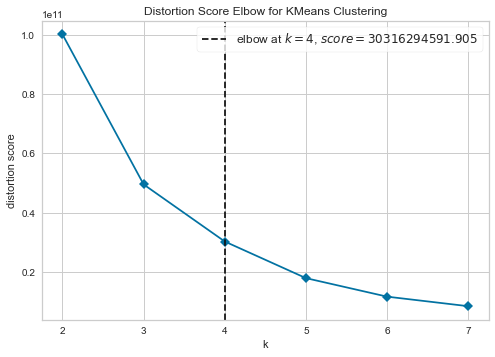

In [31]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette score

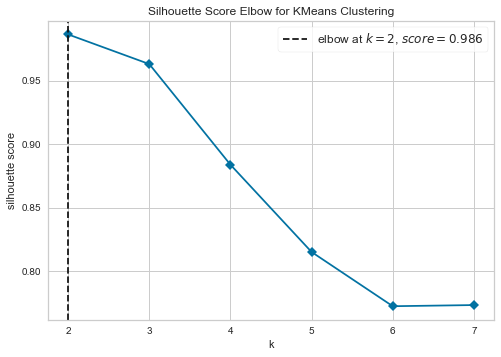

In [32]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

## 7.3 Silhouette analysis

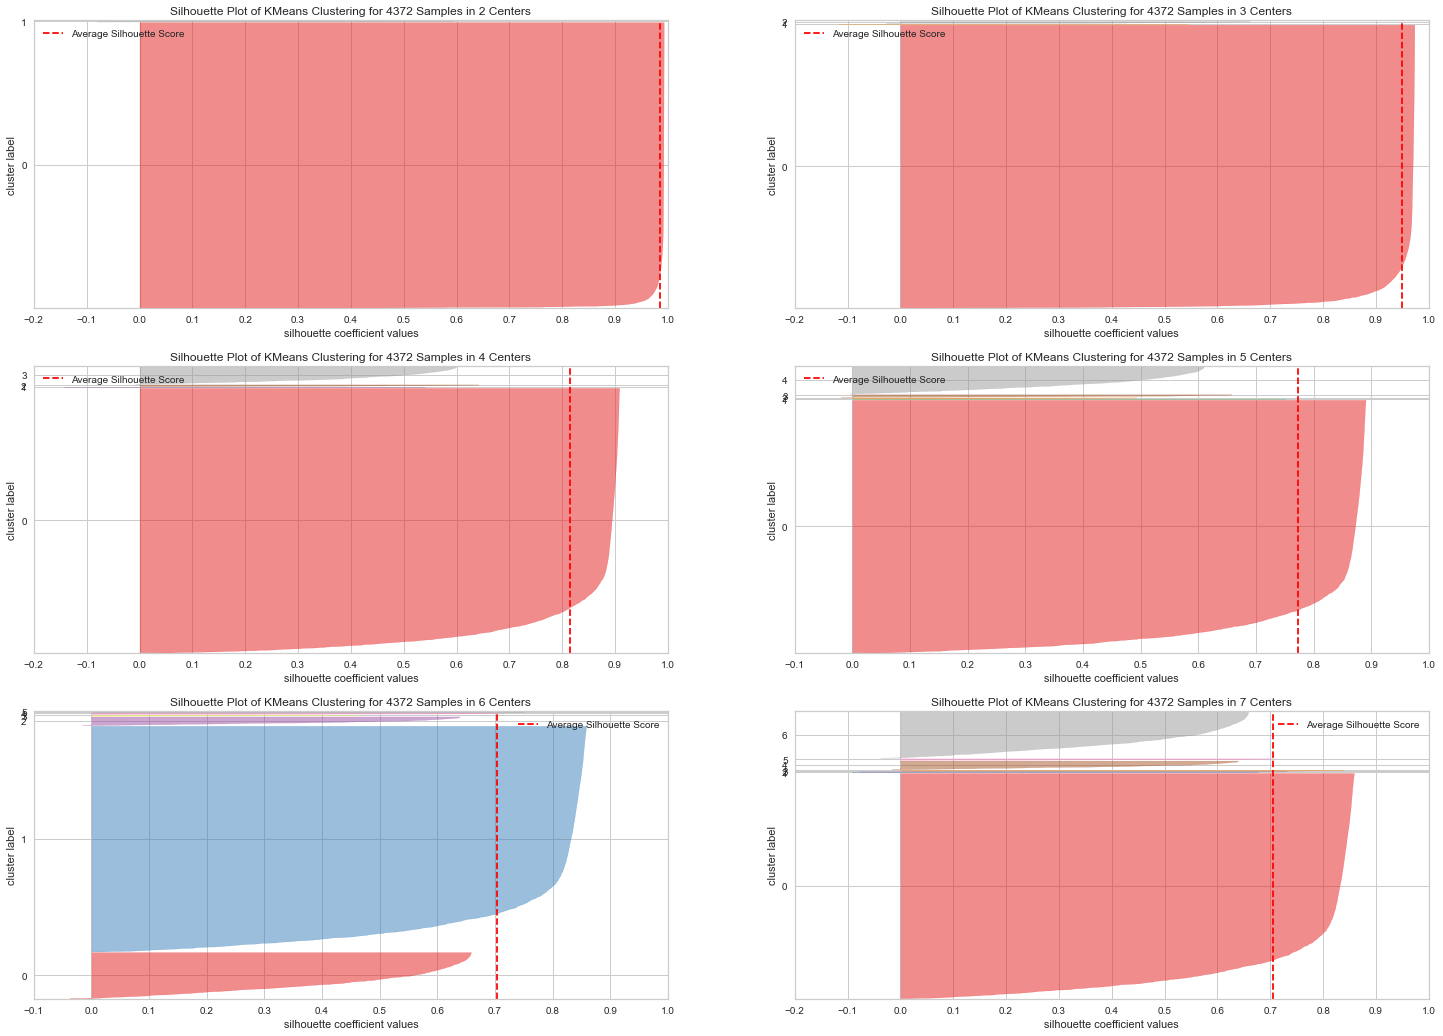

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)

    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

#  8.0 MODEL TRAINING

## 8.1 K-Means

In [222]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [223]:
## WSS (Within-cluster Sum of Square)
print('wss value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS value: {}'. format(m.silhouette_score(X, labels, metric='euclidean')))


wss value: 52830442008.00695
SS value: 0.9494677566681542


# 9.0 CLUSTER ANALYSIS

In [224]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Visualization inspection

In [225]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

## 9.2 Cluster profile

In [226]:
# number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# Avg invoice no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')


df_cluster

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,invoice_no
0,0,4335,99.153705,1372.577826,92.257901,4.614533
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,31,0.709058,40543.517742,13.290323,53.290323


**Cluster 1: (candidato a Insider)**
- Número de customers: 6 (0,14% dos customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00

**Cluster 2:**
- Número de customers: 31 (0,71% dos customers)
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52

**Cluster 3:**
- Número de customers: 4335 (99% dos customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57

# 10.0 DEPLOY TO PRODUCTION